In [105]:
import heapq
import math
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt

from collections import Counter
from itertools import chain, groupby
from random import randrange, random
from scipy.spatial import KDTree
from typing import List, Tuple

In [106]:
NOISE = 0 # Constante para marcar puntos considerados ruido
BARRIER = 1 # Constante para marcar puntos considerados barrera
CORE = 2 # Constante para marcar puntos considerados núcleo

In [107]:
## Tus respuestas
def dbscan(points: List[Tuple[float, float]], eps: float, min_points: int) -> List[int]:
    """
    Implementación básica de DBSCAN.
    points: lista de tuplas (x, y)
    eps: radio de vecindad
    min_points: número mínimo de puntos para considerar un núcleo
    Devuelve una lista de etiquetas de clúster (int) para cada punto.
    """
    n = len(points)
    # Inicializamos todas las etiquetas como None (sin clasificar)
    cluster_indices = [(None, None)] * n
    # Contador de clústeres (comenzará en 1)
    current_index = 0
    # Construimos un KD-Tree para acelerar búsquedas de vecinos
    kd_tree = KDTree(points)

    # Recorremos cada punto
    for i in range(n):
        # Si ya fue asignado a un clúster o marcado como ruido, lo saltamos
        if cluster_indices[i][0] is not None:
            continue

        # Iniciamos un nuevo conjunto de proceso con el punto i
        process_set = {i}
        # Marcamos provisionalmente el punto como ruido (podría cambiar si es núcleo)
        cluster_indices[i] = (NOISE, NOISE)
        # Avanzamos al siguiente índice de clúster
        current_index += 1

        is_cluster = 0
        # Exploramos todos los puntos en el conjunto de proceso
        while process_set:
            j = process_set.pop()
            # Buscamos vecinos de j dentro del radio eps
            neighbors = kd_tree.query_ball_point(points[j], eps)

            # Si no alcanza min_points, j no es núcleo; descartamos
            if len(neighbors) < min_points:
                if is_cluster : #Soy borde
                    cluster_indices[j] = (current_index, BARRIER)
                continue
            
            is_cluster = 1

            # j es un punto de núcleo: lo asignamos al clúster actual
            cluster_indices[j] = (current_index, CORE)

            # Revisamos cada vecino para expandir el clúster
            for p in neighbors:
                # Si p nunca fue visitado (None) o estaba marcado como ruido, lo añadimos
                if cluster_indices[p][1] is None or (p != j and cluster_indices[p][1] == NOISE):
                    process_set.add(p)

    return cluster_indices


In [108]:
def __group_points_by_cluster(points: List[Tuple[float, float]], labels: List[Tuple[int, int]]) -> List[List[Tuple[float, float]]]:
    n = len(points)
    ordered = sorted(range(n), key=lambda i: labels[i])
    clusters = groupby(ordered, key=lambda i: labels[i])
    return [[points[i] for i in group] for _, group in clusters]

In [109]:
def plot_points(ax, points, color, marker='o'):
    X, Y = zip(*points)
    
    ax.plot(X, Y, marker=marker, linestyle='none',
            markersize=8, markerfacecolor=color,
            markeredgewidth=1, markeredgecolor='k')


def plot_clusters(points, labels, point_markers=None, title='DBSCAN', ax=None):
    if point_markers is None:
        point_markers = []
        
    clusters = __group_points_by_cluster(points, labels)
    n_clusters = len(clusters)


    # Definir paleta de colores
    if NOISE in labels:
        base_colors = ['k'] + list(mcolors.TABLEAU_COLORS.values())
    else:
        base_colors = list(mcolors.TABLEAU_COLORS.values())
        

    # Asegurarnos de tener suficientes colores
    colors = [base_colors[i % len(base_colors)] for i in range(n_clusters)]
    # Definir marcadores: si no alcanza, reutilizamos 'o'
    
    markers = [point_markers[i] if i < len(point_markers) else 'o' for i in range(n_clusters)]

    if ax is None:
        fig, ax = plt.subplots()
        fig.suptitle(title)
        ax.set_aspect('equal')
        
    for i, cluster in enumerate(clusters):
        plot_points(ax, cluster, colors[i], markers[i])


In [110]:
def random_point(radius):
    return (random() * radius - radius / 2, random() * radius - radius / 2)

In [111]:
def create_spherical_cluster(centroid, radius, n_points):
    def random_point_in_circle():
        alpha = random() * 2 * math.pi
        r = radius * math.sqrt(random())
        x = centroid[0] + r * math.cos(alpha)
        y = centroid[1] + r * math.sin(alpha)
        return (x, y)
    return [random_point_in_circle() for _ in range(n_points)]

In [112]:
k = 10
data_centroids = [random_point(10) for _ in range(k)]
data_clusters = [create_spherical_cluster(P, 0.25 + random(), randrange(10, 100)) for P in data_centroids]
noise = [random_point(10) for _ in range(50)]
points = [p for C in data_clusters for p in C] + noise

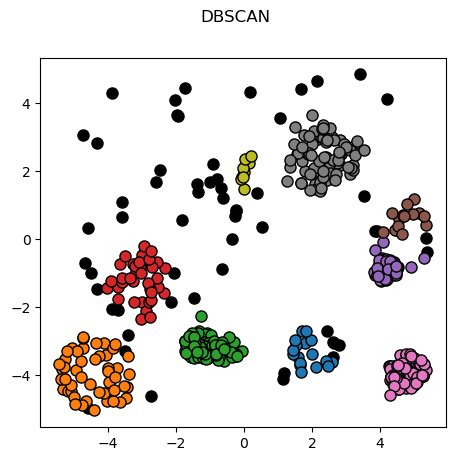

In [113]:
labels = dbscan(points, eps=0.5, min_points=8)
lab = [e[0] for e in labels]
plot_clusters(points, lab)

In [114]:
list_points = [[] for _ in range(3)]
list_labels = [[] for _ in range(3)]

for i in range(len(points)):
    list_points[labels[i][1]].append(points[i])
    list_labels[labels[i][1]].append(labels[i][0])
for i in range(3) :
    assert len(list_points[i]) == len(list_labels[i]), f"Error en el tamaño de los puntos y etiquetas para el clúster {i}"


64


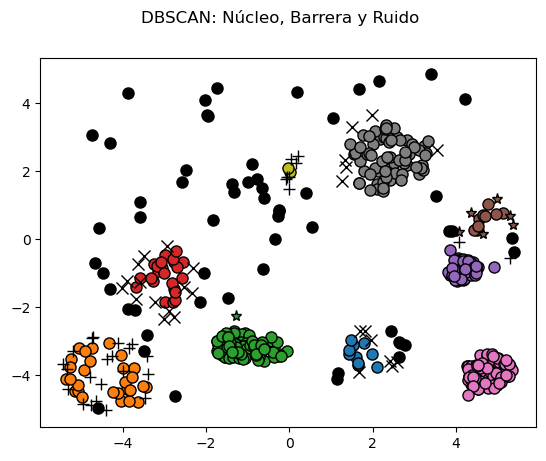

In [115]:

fig, ax = plt.subplots()
fig.suptitle('DBSCAN: Núcleo, Barrera y Ruido')
signs =  ['x','+','*']
point_markers = [signs[i % len(signs)] for i in range(len(list_points[BARRIER]))]


plot_clusters(list_points[CORE], list_labels[CORE], point_markers=['o'], title='', ax=ax)
plot_clusters(list_points[BARRIER], list_labels[BARRIER], point_markers=point_markers, title='', ax=ax)
plot_clusters(list_points[NOISE], list_labels[NOISE], point_markers=['o'], title='', ax=ax)
print(len(list_points[BARRIER]))
plt.show()

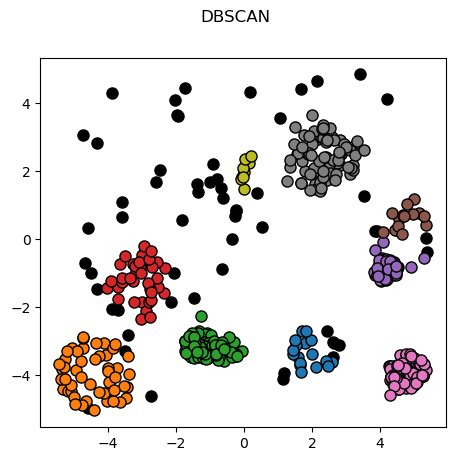

In [116]:
plot_clusters(points, lab)


6. **Eficiencia y complejidad**

   * Mide el tiempo de ejecución de `dbscan` para distintos tamaños de dataset (p.ej. 1 000; 10 000; 100 000 puntos).
   * Compara tiempos usando KD-Tree, brute force y, opcionalmente, un Ball-Tree de `scipy`.
   * Grafica la complejidad empírica (tiempo vs. número de puntos) y discute.

In [117]:
def generate_points(n):
    k = 10
    num_noise = int(math.sqrt(n))//2
    data_centroids = [random_point(10) for _ in range(k)]
    data_clusters = [create_spherical_cluster(P, 0.25 + random(), n//k) for P in data_centroids]
    noise = [random_point(10) for _ in range(num_noise)]
    points = [p for C in data_clusters for p in C] + noise
    return points

In [ ]:
def euclidean_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def brute_force_neighbors(points: List[Tuple[float, float]], idx: int, eps: float) -> List[int]: 
    return [i for i, p in enumerate(points) if euclidean_distance(points[idx], p) <= eps]


def knn_neighbors(points: List[Tuple[float, float]], idx: int, eps: float) -> List[int]:
    kd_tree = KDTree(points)
    neighbors = kd_tree.query_ball_point(points[idx], eps)
    return neighbors

## Tus respuestas
def dbscan(points: List[Tuple[float, float]], eps: float, min_points: int, dis_func = None) -> List[int]:
    """
    Implementación básica de DBSCAN.
    points: lista de tuplas (x, y)
    eps: radio de vecindad
    min_points: número mínimo de puntos para considerar un núcleo
    Devuelve una lista de etiquetas de clúster (int) para cada punto.
    """
    n = len(points)
    # Inicializamos todas las etiquetas como None (sin clasificar)
    cluster_indices = [(None, None)] * n
    # Contador de clústeres (comenzará en 1)
    current_index = 0
    # Construimos un KD-Tree para acelerar búsquedas de vecinos
 
    # Recorremos cada punto
    for i in range(n):
        # Si ya fue asignado a un clúster o marcado como ruido, lo saltamos
        if cluster_indices[i][0] is not None:
            continue

        # Iniciamos un nuevo conjunto de proceso con el punto i
        process_set = {i}
        # Marcamos provisionalmente el punto como ruido (podría cambiar si es núcleo)
        cluster_indices[i] = (NOISE, NOISE)
        # Avanzamos al siguiente índice de clúster
        current_index += 1

        is_cluster = 0
        # Exploramos todos los puntos en el conjunto de proceso
        while process_set:
            j = process_set.pop()
            # Buscamos vecinos de j dentro del radio eps
            neighbors = dis_func(points, j, eps)

            # Si no alcanza min_points, j no es núcleo; descartamos
            if len(neighbors) < min_points:
                if is_cluster : #Soy borde
                    cluster_indices[j] = (current_index, BARRIER)
                continue
            
            is_cluster = 1

            # j es un punto de núcleo: lo asignamos al clúster actual
            cluster_indices[j] = (current_index, CORE)

            # Revisamos cada vecino para expandir el clúster
            for p in neighbors:
                # Si p nunca fue visitado (None) o estaba marcado como ruido, lo añadimos
                if cluster_indices[p][1] is None or (p != j and cluster_indices[p][1] == NOISE):
                    process_set.add(p)

    return cluster_indices


[100 300 500 700 900]


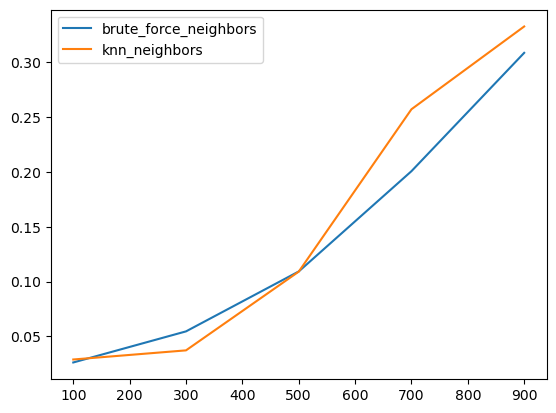

In [ ]:
import numpy as np
import time

from streamlit import title
sizes = np.arange(100, 1000, 200)

print(sizes)
x_data = [[] for _ in range(2)]
y_data = [[] for _ in range(2)]

metrics = [brute_force_neighbors, knn_neighbors]

for n in sizes:
    points = generate_points(n)
    for i, metric in enumerate(metrics):
        if(metric == brute_force_neighbors and n > 1000):
            continue
            
        x_data[i].append(n)
        start = time.time()
        labels = dbscan(points, eps=0.005, min_points=8, dis_func=metric)
        y_data[i].append(time.time() - start)

for i, metric in enumerate(metrics):
    plt.plot(x_data[i], y_data[i], label=metric.__name__)
    
plt.legend()
plt.show()  

In [120]:
k = 10
data_centroids = [random_point(10) for _ in range(k)]
data_clusters = [create_spherical_cluster(P, 0.25 + random(), randrange(10, 100)) for P in data_centroids]
noise = [random_point(10) for _ in range(50)]
points = [p for C in data_clusters for p in C] + noise



In [121]:
from numpy import inf


#Implementamos un DSU simple 
maxn = 10000
parent_cluster = [i for i in range(maxn)]

def find(x):
    if parent_cluster[x] == x:
        return x
    parent_cluster[x] = find(parent_cluster[x])
    return parent_cluster[x]

def union(x, y):
    root_x = find(x)
    root_y = find(y)
    
    if root_x != root_y:
        parent_cluster[root_y] = root_x

## Tus respuestas
def dbscan_add_point( target: Tuple[float, float], eps: float, min_points: int, kd_tree, id:int) :
    neighbors = kd_tree.query_ball_point(target, eps)
    for p in neighbors :
        union(p, id)

In [122]:
inf = 100000
data = [(-inf, -inf)]
kd_tree = KDTree(data)

for id, point in enumerate(points) :
    parent_cluster[id] = id
    kd_tree = KDTree(data)
    dbscan_add_point(point, eps=0.5, min_points=8, kd_tree=kd_tree, id = id)
    data.append(point)

[559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571,

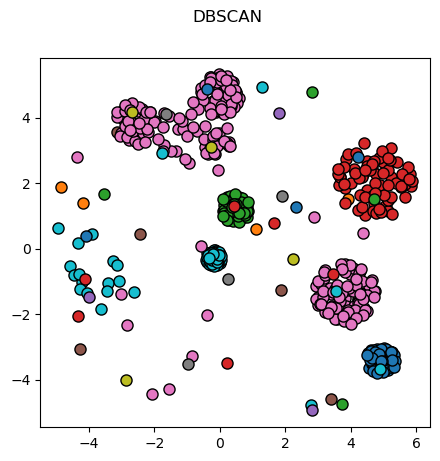

In [123]:
parent_cluster = [find(i) for i in range(1, len(data))]
print(parent_cluster)
plot_clusters(points, parent_cluster)

In [124]:
import numpy as np
parent_cluster_np = np.array(parent_cluster)
from numpy import unique    
print(unique(parent_cluster_np))

[131 205 206 292 366 412 426 439 553 559 567 568 569 571 573 574 576 577
 578 581 583 585 587 588 589 590 591 594 595 598 601 602 605 606 609 610
 611 612 615 616 617]
